### Imports

In [1]:
# Model Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import layers
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

2023-06-21 20:13:21.005139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 20:13:21.110764: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-21 20:13:22.881152: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/us

In [4]:
# File Management Libraries and Helper Functions
import os
from pathlib import Path
import glob
import pickle

from breed_helpers import *

In [5]:
# Object anda Data Structure Management Libraries
from PIL import Image
import pandas as pd
import numpy as np

### Preprocessing

In [6]:
image_root = 'data/Images'
annot_root = 'data/Annotation'

dog_paths = np.array(glob.glob(image_root + '/*/*'))
annotations = np.array(glob.glob(annot_root + '/*/*'))
breed_list = [x.split('-', 1)[-1] for x in os.listdir(image_root)]

for i in range(len(annotations)):
        dog_paths[i] = dog_paths[i].replace('\\','/')
        annotations[i] = annotations[i].replace('\\','/')

# for i in range(len(breed_list)):
#     breed_list[i] = breed_list[i].split('-', 1)[-1]

In [7]:
df = pd.DataFrame(
        {'Breed': [get_dog_breed(x) for x in annotations], 
        'Folder_Dir': [x.split('/')[2].split('-')[0] for x in annotations], 
        'Image_Dir': [x.split('/')[-1] for x in annotations],
        'Bbox': [get_bbox(x) for x in annotations],
        'Num_Dogs': [len(get_bbox(x)) for x in annotations],
        'Image_Path': dog_paths})
df.head()

,Breed,Folder_Dir,Image_Dir,Bbox,Num_Dogs,Image_Path
0,Chihuahua,n02085620,n02085620_10074,"[(25, 10, 276, 498)]",1,data/Images/n02085620-Chihuahua/n02085620_1062...
1,Chihuahua,n02085620,n02085620_10131,"[(49, 9, 393, 493)]",1,data/Images/n02085620-Chihuahua/n02085620_1097...
2,Chihuahua,n02085620,n02085620_10621,"[(142, 43, 335, 250)]",1,data/Images/n02085620-Chihuahua/n02085620_1123...
3,Chihuahua,n02085620,n02085620_1073,"[(0, 27, 312, 498)]",1,data/Images/n02085620-Chihuahua/n02085620_1125...
4,Chihuahua,n02085620,n02085620_10976,"[(90, 104, 242, 452)]",1,data/Images/n02085620-Chihuahua/n02085620_1133...


In [17]:
print(breed_list)
print(annotations)
print(dog_paths)

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'Lhasa', 'West_Highland_white_terrier', 'flat-coated_retriever', 'curly-coated_retriever', 'golden_retr

### Viewing/Expiriments

In [20]:
df.head(11)

,Breed,Folder_Dir,Image_Dir,Bbox,Num_Dogs,Image_Path
0,Chihuahua,n02085620,n02085620_10074,"[(25, 10, 276, 498)]",1,data/Images/n02085620-Chihuahua/n02085620_1062...
1,Chihuahua,n02085620,n02085620_10131,"[(49, 9, 393, 493)]",1,data/Images/n02085620-Chihuahua/n02085620_1097...
2,Chihuahua,n02085620,n02085620_10621,"[(142, 43, 335, 250)]",1,data/Images/n02085620-Chihuahua/n02085620_1123...
3,Chihuahua,n02085620,n02085620_1073,"[(0, 27, 312, 498)]",1,data/Images/n02085620-Chihuahua/n02085620_1125...
4,Chihuahua,n02085620,n02085620_10976,"[(90, 104, 242, 452)]",1,data/Images/n02085620-Chihuahua/n02085620_1133...
5,Chihuahua,n02085620,n02085620_11140,"[(17, 38, 451, 253)]",1,data/Images/n02085620-Chihuahua/n02085620_1152...
6,Chihuahua,n02085620,n02085620_11238,"[(39, 191, 145, 383)]",1,data/Images/n02085620-Chihuahua/n02085620_1169...
7,Chihuahua,n02085620,n02085620_11258,"[(76, 30, 363, 375)]",1,data/Images/n02085620-Chihuahua/n02085620_1181...
8,Chihuahua,n02085620,n02085620_11337,"[(59, 37, 229, 179)]",1,data/Images/n02085620-Chihuahua/n02085620_1194...
9,Chihuahua,n02085620,n02085620_11477,"[(317, 95, 558, 459)]",1,data/Images/n02085620-Chihuahua/n02085620_1205...


In [21]:
for i in range(len(images)):
    if (np.shape(images[i]) != (299, 299, 3)):
        print(i)
        print(images[i])

NameError: name 'images' is not defined

In [ ]:
item = df['Image_Path'].iloc[13680]
item = Image.open(item).convert('RGB').resize((desired_width, desired_height))
np.shape(np.asarray(item))

In [ ]:
X = np.stack(X)

In [ ]:
x_len = list()
y_len = list()

for bbox_arr in df.Bbox:
    for bbox in bbox_arr:
        xmin, ymin, xmax, ymax = bbox
        x_len.append(xmax-xmin)
        y_len.append(ymax-ymin)

x_avg = sum(x_len)/len(x_len)
x_min = min(x_len)
x_max = max(x_len)

y_avg = sum(y_len)/len(y_len)
y_min = min(y_len)
y_max = max(y_len)

print(f'x_min: {x_min}, x_avg: {x_avg}, x_max: {x_max}, y_min: {y_min}, y_avg: {y_avg}, y_max: {y_max}')
print(sorted(x_len, reverse=True))
print(sorted(y_len, reverse=True))

In [ ]:
print(annotations[0])
assert get_image_path(annotations[0]) == dog_paths[0]
print(dog_paths[0])

In [ ]:
for i in range(8):
    print(get_bbox(annotations[i]))

In [ ]:
plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2, 4, i+1)

    bbox = get_bbox(annotations[i])

    plt.axis("off")
    dog = get_image_path(annotations[i])
    im = Image.open(dog)
    #im = im.resize((256,256), Image.ANTIALIAS)
    plt.imshow(im)
    
    for j in range(len(bbox)):
        xmin, ymin, xmax, ymax = bbox[j]
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin]) # showing border
        plt.text(xmin, ymin, get_dog_breed(annotations[i]), bbox={'ec': None})

In [ ]:
# def create_cropped():
#     #plt.figure(figsize=(10,6))
#     for i in range(len(dog_image_paths)):
#         bbox = get_bbox(annotations[i])
#         dog = get_image_path(annotations[i])
#         im = Image.open(dog)
#         for j in range(len(bbox)):
#             im2 = im.crop(bbox[j])
#             #im2 = im2.resize((331,331), Image.ANTIALIAS)
#             new_path = dog.replace('data/Images/','data/Cropped/')
#             new_path = new_path.replace('.jpg', '-' + str(j) + '.jpg')
#             im2 = im2.convert('RGB')
#             head, tail = os.path.split(new_path)
#             Path(head).mkdir(parents=True, exist_ok=True)
#             im2.save(new_path)

### Train Test Split

In [78]:
with open('data/shuffled_brute_resized_299_images.pickle', 'rb') as file:
    X, y = pickle.load(file).values()
y = [breed_to_idx[i] for i in y]

In [19]:
print(f'X size:{np.shape(X)}, y size:{np.shape(y)}')

X size:(20580, 299, 299, 3), y size:(20580,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, stratify = y_test, random_state = 1)
print("X train, test, val: ", len(X_train), len(X_test), len(X_val))
print("y train, test, val: ", len(y_train), len(y_test), len(y_val))

X train, test, val:  16464 2058 2058
y train, test, val:  16464 2058 2058


### Model Defintion

In [21]:
# class lr_scheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
#     def __init__(self, d_model, warmup_steps=4000, ramp_scalar=1, decay_scalar=1):
#         super().__init__()

#         self.d_model = d_model
#         self.d_model = tf.cast(self.d_model, tf.float32)
#         self.ramp_scalar = ramp_scalar
#         self.decay_scalar = decay_scalar
        
#         self.warmup_steps = warmup_steps

#     def __call__(self, step):
#         step = tf.cast(step, dtype=tf.float32)
#         arg1 = tf.math.rsqrt(step) * self.decay_scalar
#         arg2 = step * (self.warmup_steps ** -1.5) * self.ramp_scalar
#         return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
#     def get_config(self):
#         return {
#             "d_model": self.d_model,
#             "warmup_steps": self.warmup_steps,
#         }
    
#     def from_config(cls, config):
#          return cls(**config)

[1e-05, 6.505118493965467e-06, 1.3998986787088662e-05, 2.115828331026577e-05, 2.634984602010088e-05, 2.903283423186413e-05, 2.9396621317932858e-05, 2.797955953984193e-05, 2.540189142522509e-05, 2.221806032905684e-05, 1.8856097352877635e-05, 1.560936043583151e-05, 1.2654326695550147e-05, 1.0077683322564948e-05, 7.903473325235455e-06, 6.116060562840309e-06, 4.677633681846914e-06, 3.5404997968665235e-06, 2.6550669454638992e-06, 1.974568819142437e-06, 1.4574973926162888e-06, 1.0685271446467287e-06, 7.785179664389633e-07, 5.640095676289399e-07, 4.0648112766012214e-07]


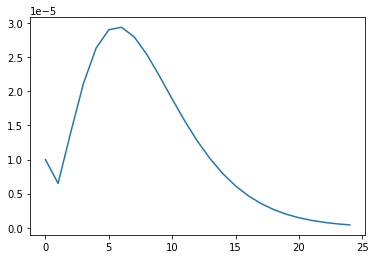

In [66]:
learning_rate_init = 0.00001

def lr_scheduler(epoch):
    e = 2.71828
    epoch += 1
   
    if epoch == 1:
        return learning_rate_init
    
    elif epoch >= 2 and epoch <= 40:
        return (0.2*epoch**3)* e**(-0.45*epoch)*learning_rate_init
    
    else:
        return lr_scheduler(40-1)

stage = [i for i in range(0,25)]
learning_rate = [lr_scheduler(x) for x in stage]
plt.plot(stage, learning_rate)
print(learning_rate)

In [22]:
def data_augmentation(input, severity):
    x = layers.RandomFlip("horizontal")(input)
    x = layers.RandomTranslation(severity, severity)(x)
    x = layers.RandomZoom(severity)(x)
    x = layers.RandomRotation(2*severity)(x)
    x = layers.RandomContrast(severity)(x)
    return x

In [23]:
def feature_learning(input, cnn_modules=3, starting_features=32, feature_ramp=2):
    features = starting_features

    x = layers.Conv2D(starting_features, kernel_size=5, activation='relu')(input)
    x = layers.MaxPooling2D(3, strides=2)(x)

    for i in range(cnn_modules-1):
        features *= feature_ramp
        x = layers.Conv2D(features, kernel_size=5, activation='relu')(x)
        x = layers.MaxPooling2D(2, strides=1)(x)
    
    return x

In [24]:
# def cnn_classifier_bridge(output_size):
#     x = layers.Flatten()

In [25]:
def dense_classifier(input, num_classes, dff=1024, dff_decay=0.5, dropout=0.1):
    counter = 0
    x = layers.Flatten()(input)

    x = layers.Dense(dff, activation='relu')(x)
    x = layers.Dropout(dropout)(x)

    while counter > num_classes:
        counter += 1
        x = layers.Dense(dff * dff_decay**counter, activation='relu')(x)
        x = layers.Dropout(dropout)(x)

    return x, layers.Dense(num_classes, activation='softmax')(x)

In [61]:
def Xception_dense_classifier(model, num_classes, dff=1024, dff_decay=0.5, dropout=0.1):
    counter = 0
    model.add(layers.Flatten())

    model.add(layers.Dense(dff, activation='relu'))
    model.add(layers.Dropout(dropout))

    while dff * dff_decay**counter > num_classes:
        counter += 1
        model.add(layers.Dense(dff * dff_decay**counter, activation='relu'))
        model.add(layers.Dropout(dropout))

    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [67]:
def get_compiled_model(input_shape):    
        learning_rate = 0.001
        
        #optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad = False)

        #input = layers.Input(input_shape)
        #data_aug = data_augmentation(input, severity)
        #feature_extract = feature_learning(data_aug, cnn_modules, starting_features, feature_ramp)
        #classifier, output = dense_classifier(feature_extract, num_classes, dff, dff_decay, dropout_rate)


        base_model = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False, pooling='avg')
        base_model.trainable = False
        
        model = Xception_dense_classifier(keras.Sequential(base_model), num_classes, dff, dff_decay, dropout_rate)

        model.compile(
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])
        return model

### Model Training

In [68]:
severity = 0.1

cnn_modules = 4
starting_features = 16
feature_ramp = 1

dff = 2048
dff_decay = 0.5
dropout_rate = 0.2

num_classes = len(np.unique(y_train))
batch_size = 64
epochs = 20
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train) 
class_weights=dict(zip(np.unique(y_train), class_weights))

In [69]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# # Apply `data_augmentation` to the training images.
# train_ds = train_ds.map(
#     lambda img, label: (data_augmentation(img), label),
#     num_parallel_calls=tf.data.AUTOTUNE,
# )
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [74]:
scheduler = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
#early_stop = keras.EarlyStopping(monitor='val_accuracy', patience = 6, mode='max', min_delta=1, verbose=1)

model = get_compiled_model((299, 299, 3))
model.build((16464, 299, 299, 3))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_146 (Dense)           (None, 2048)              4196352   
                                                                 
 dropout_138 (Dropout)       (None, 2048)              0         
                                                                 
 dense_147 (Dense)           (None, 1024)              2098176   
                                                                 
 dropout_139 (Dropout)       (None, 1024)              0         
                                                                 
 dense_148 (Dense)           (None, 512)              

In [75]:
history = model.fit(train_dataset, batch_size=batch_size, epochs=epochs, 
                        validation_data=val_dataset,
                        class_weight=class_weights, verbose=1, callbacks = [scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20
258/258 [==============================] - 139s 528ms/step - loss: 6.0622 - accuracy: 0.0075 - val_loss: 4.8072 - val_accuracy: 0.0073 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 6.505118493965467e-06.
Epoch 2/20
258/258 [==============================] - 138s 534ms/step - loss: 5.1028 - accuracy: 0.0087 - val_loss: 4.7986 - val_accuracy: 0.0063 - lr: 6.5051e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.3998986787088662e-05.
Epoch 3/20
258/258 [==============================] - 136s 529ms/step - loss: 4.9712 - accuracy: 0.0080 - val_loss: 4.7899 - val_accuracy: 0.0102 - lr: 1.3999e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.115828331026577e-05.
Epoch 4/20
258/258 [==============================] - 135s 523ms/step - loss: 4.8881 - accuracy: 0.0086 - val_loss: 4.7885 - val_accuracy: 0.0102 - lr: 2.1158e-05

Epoch 5: LearningRateScheduler setting lea

### Training Plots

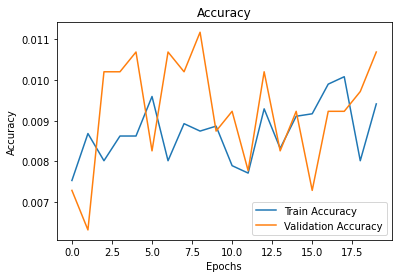

In [76]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

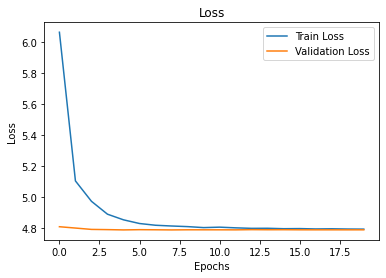

In [77]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.axis([75, 200, 1.2, 2.2])
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [33]:
learning_rate = lr_scheduler(d_model)
lr = np.array([])
for i in range(1, 100):
    lr = np.append(lr, learning_rate.__call__(300*i))
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.plot(lr, label='Learning Rate')
#plt.axis([0, 300, 0, 0.000125])
plt.legend()

# learning_rate = lr_scheduler(d_model, ramp_scalar=1, decay_scalar=1)
# steps_per_epoch = np.ceil((np.shape(X_train)[0]/batch_size))
# print(steps_per_epoch)
# lr = np.array([])
# for i in range(1, np.maximum(epochs+10, 30)):
#     lr = np.append(lr, learning_rate.__call__((i*steps_per_epoch)))

NameError: name 'lr_scheduler' is not defined

### Model Evaluation

In [34]:
pred = model.predict(X_test)

65/65 [==============================] - 2s 17ms/step


In [35]:
def norm_cm(cm):
    return np.array([cm[i] / np.sum(cm[i]) for i in range(len(cm))])
def accuracy(cm):
    return cm.diagonal().sum() / cm.sum()
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))

normalized_cm = norm_cm(cm)
print('accuracy', accuracy(cm))

accuracy 0.013119533527696793


<AxesSubplot:>

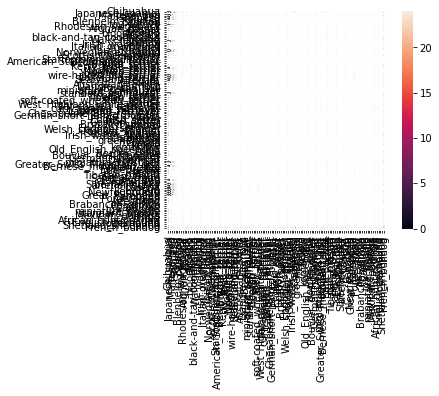

In [36]:
sns.heatmap(cm, xticklabels=breed_list, yticklabels=breed_list, annot=True, fmt='g', square=True)

<AxesSubplot:>

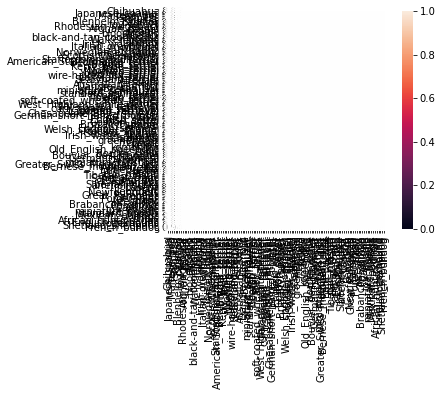

In [37]:
sns.heatmap(normalized_cm, xticklabels=breed_list, yticklabels=breed_list, annot=True, fmt='.2f', square=True)